In [1]:
import numpy
from scipy.linalg import solve

In [3]:
def constructMatrix(nx, ny, sigma):
    
    A = numpy.zeros(((nx-2)*(ny-2),(nx-2)*(ny-2)))
    
    row_number = 0 # row counter
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            
            # Corners
            if i==1 and j==1: # Bottom left corner 
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                
            elif i==nx-2 and j==1: # Bottom right corner 
                A[row_number,row_number] = 1/sigma+3 # Set diagonal
                A[row_number,row_number-1] = -1      # Fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                
            elif i==1 and j==ny-2: # Topleft corner
                A[row_number,row_number] = 1/sigma+3   # Set diagonal
                A[row_number,row_number+1] = -1        # fetch i+1
                A[row_number,row_number-(nx-2)] = -1   # fetch j-1
                
            elif i==nx-2 and j==ny-2: #top right corner
                A[row_number,row_number] = 1/sigma+2   # Set diagonal
                A[row_number,row_number-1] = -1        # Fetch i-1
                A[row_number,row_number-(nx-2)] = -1   # fetch j-1
              
            # Sides
            elif i==1: #Left boundary 
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
            
            elif i==nx-2: #  Right boundary 
                A[row_number,row_number] = 1/sigma+3 # set diagonal
                A[row_number,row_number-1] = -1      # Fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
                
            elif j==1: # bottom boundary
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                
            elif j==ny-2: # Top boundary
                A[row_number,row_number] = 1/sigma+3 # set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
                
            # Interior points
            else:
                A[row_number,row_number] = 1/sigma+4 # Setdiagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
                
            row_number += 1 
    
    return A           

In [4]:
def generateRHS(nx, ny, sigma, T, T_bc):
    
    RHS = numpy.zeros((nx-2)*(ny-2))
    
    row_number = 0 # row counter
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            
            # Corners
            if i==1 and j==1: # Bottomleft corner 
                RHS[row_number] = T[j,i]*1/sigma + 2*T_bc
                
            elif i==nx-2 and j==1: # Bottom right corner 
                RHS[row_number] = T[j,i]*1/sigma + T_bc
                           
            elif i==1 and j==ny-2: # Top left Corner 
                RHS[row_number] = T[j,i]*1/sigma + T_bc
                
            elif i==nx-2 and j==ny-2: # Top Right corner 
                RHS[row_number] = T[j,i]*1/sigma 
              
            # Sides
            elif i==1: # Left boundary 
                RHS[row_number] = T[j,i]*1/sigma + T_bc
            
            elif i==nx-2: # Right boundary
                RHS[row_number] = T[j,i]*1/sigma 
                
            elif j==1: # Bottomboundary 
                RHS[row_number] = T[j,i]*1/sigma + T_bc
                
            elif j==ny-2: # Top boundary 
                RHS[row_number] = T[j,i]*1/sigma
                
            # Interior points
            else:
                RHS[row_number] = T[j,i]*1/sigma 
                
            row_number += 1 
    
    return RHS

In [5]:
def map_1Dto2D(nx, ny, T_1D, T_bc):
   
    T = numpy.zeros((ny,nx))
    
    row_number = 0
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            T[j,i] = T_1D[row_number]
            row_number += 1
    # Dirichlet BC
    T[0,:] = T_bc
    T[:,0] = T_bc
    #Neumann BC
    T[-1,:] = T[-2,:]
    T[:,-1] = T[:,-2]
    
    return T    

In [6]:
def btcs_2D(T, A, nt, sigma, T_bc, nx, ny, dt):
    j_mid = int((numpy.shape(T)[0])/2)
    i_mid = int((numpy.shape(T)[1])/2)
    
    for t in range(nt):
        Tn = T.copy()
        b = generateRHS(nx, ny, sigma, Tn, T_bc) # Use numpy.linalg.solve
        T_interior = solve(A,b)
        T = map_1Dto2D(nx, ny, T_interior, T_bc)
        
        
        if T[j_mid, i_mid] >= 70:
            print ("plate reached 70C at time {0:.2f}s, in time step {1:d}.".format(dt*t, t))
            break
        
    if T[j_mid, i_mid]<70:
        print ("Center has not reached 70C yet, it is only {0:.2f}C.".format(T[j_mid, i_mid]))
        
    return T

In [7]:
alpha = 1e-4
L = 1.0e-2
H = 1.0e-2
nx = 21
ny = 21
nt = 300
dx = L/(nx-1)
dy = H/(ny-1)
x = numpy.linspace(0,L,nx)
y = numpy.linspace(0,H,ny)
T_bc = 100
Ti = numpy.ones((ny, nx))*20
Ti[0,:]= T_bc
Ti[:,0] = T_bc

In [8]:
sigma = 0.25
A = constructMatrix(nx, ny, sigma)

In [9]:
dt = sigma * min(dx, dy)**2 / alpha
T = btcs_2D(Ti.copy(), A, nt, sigma, T_bc, nx, ny, dt)

plate reached 70C at time 0.16s, in time step 256.


In [10]:
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams, cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

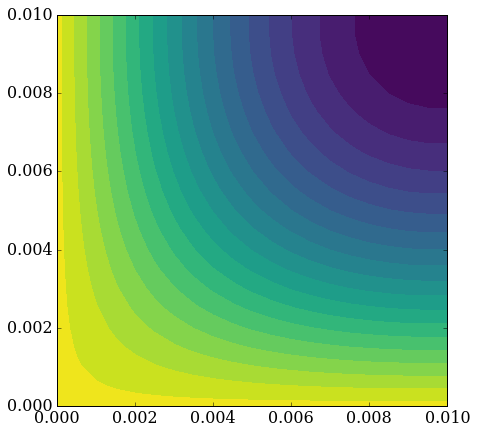

In [11]:
pyplot.figure(figsize=(7,7))
pyplot.contourf(x,y,T,20, cmap=cm.viridis);

Center has not reached 70C yet, it is only 48.39C.


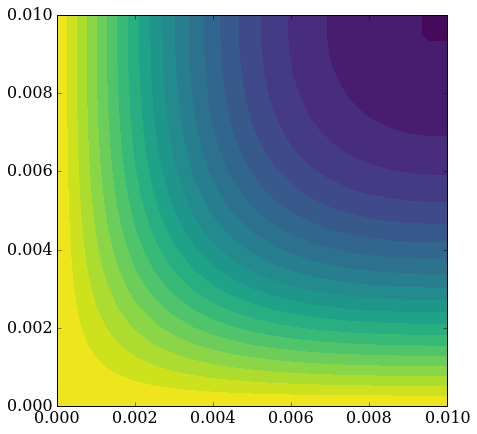

In [12]:
alpha = 1e-4
L = 1.0e-2
H = 1.0e-2
nx = 21
ny = 21
nt = 300
dx = L/(nx-1)
dy = H/(ny-1)
x = numpy.linspace(0,L,nx)
y = numpy.linspace(0,H,ny)
T_bc = 100
Ti = numpy.ones((ny, nx))*20
Ti[0,:]= T_bc
Ti[:,0] = T_bc
sigma = 0.10
A = constructMatrix(nx, ny, sigma)
dt = sigma * min(dx, dy)**2 / alpha
T = btcs_2D(Ti.copy(), A, nt, sigma, T_bc, nx, ny, dt)
pyplot.figure(figsize=(7,7))
pyplot.contourf(x,y,T,20, cmap=cm.viridis);

Center has not reached 70C yet, it is only 23.13C.


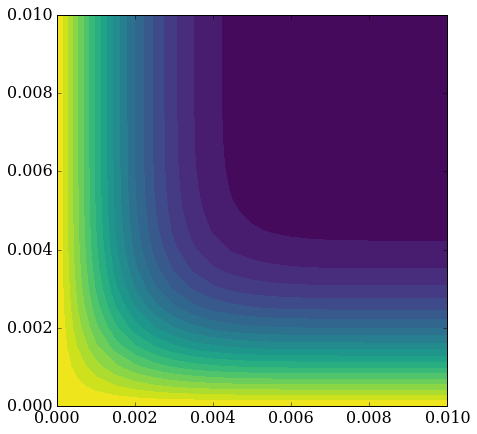

In [13]:
alpha = 1e-4
L = 1.0e-2
H = 1.0e-2
nx = 21
ny = 21
nt = 300
dx = L/(nx-1)
dy = H/(ny-1)
x = numpy.linspace(0,L,nx)
y = numpy.linspace(0,H,ny)
T_bc = 100
Ti = numpy.ones((ny, nx))*20
Ti[0,:]= T_bc
Ti[:,0] = T_bc
sigma = 0.03
A = constructMatrix(nx, ny, sigma)
dt = sigma * min(dx, dy)**2 / alpha
T = btcs_2D(Ti.copy(), A, nt, sigma, T_bc, nx, ny, dt)
pyplot.figure(figsize=(7,7))
pyplot.contourf(x,y,T,20, cmap=cm.viridis);

plate reached 70C at time 0.16s, in time step 160.


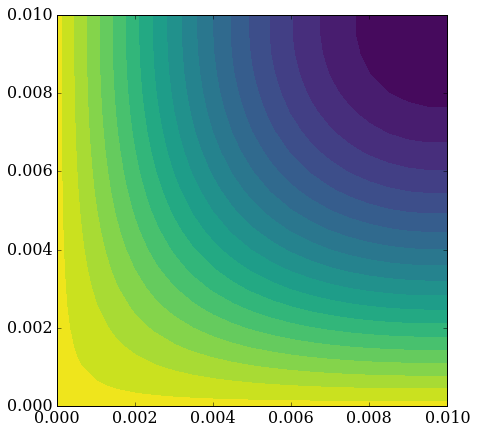

In [14]:
alpha = 1e-4
L = 1.0e-2
H = 1.0e-2
nx = 21
ny = 21
nt = 300
dx = L/(nx-1)
dy = H/(ny-1)
x = numpy.linspace(0,L,nx)
y = numpy.linspace(0,H,ny)
T_bc = 100
Ti = numpy.ones((ny, nx))*20
Ti[0,:]= T_bc
Ti[:,0] = T_bc
sigma = 0.40
A = constructMatrix(nx, ny, sigma)
dt = sigma * min(dx, dy)**2 / alpha
T = btcs_2D(Ti.copy(), A, nt, sigma, T_bc, nx, ny, dt)
pyplot.figure(figsize=(7,7))
pyplot.contourf(x,y,T,20, cmap=cm.viridis);